In [49]:
#main libraries
import os
import re
import pickle
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


#importing machine learning libraries
from sklearn.svm import SVR
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

In [2]:
full_df = pd.read_csv('Bengaluru_House_Data.csv')

In [3]:
full_df = full_df.drop(columns =['availability','balcony','area_type','society'])
full_df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Richards Town,4 BHK,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00


In [4]:
full_df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [5]:
full_df['size'].fillna('0 BHK', inplace=True)
full_df['bath'].fillna(0, inplace=True)
full_df['location'].fillna('NA', inplace=True) 
full_df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [6]:
full_df['size'] = full_df['size'].apply(lambda x: int(x.split(' ')[0]))
full_df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056,2.0,39.07
1,Chikka Tirupathi,4,2600,5.0,120.00
2,Uttarahalli,3,1440,2.0,62.00
3,Lingadheeranahalli,3,1521,3.0,95.00
4,Kothanur,2,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5,3453,4.0,231.00
13316,Richards Town,4,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2,1141,2.0,60.00
13318,Padmanabhanagar,4,4689,4.0,488.00


In [7]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [8]:
full_df.total_sqft = full_df.total_sqft.apply(convert_sqft_to_num)
full_df.total_sqft

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13315    3453.0
13316    3600.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 13320, dtype: float64

In [9]:
#descriptive statistics summary
full_df['price'].describe()

count    13320.000000
mean       112.565627
std        148.971674
min          8.000000
25%         50.000000
50%         72.000000
75%        120.000000
max       3600.000000
Name: price, dtype: float64

C:\Users\Dishita Neve\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



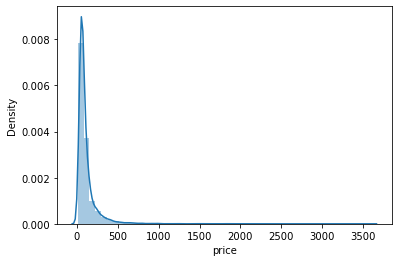

In [10]:
#histogram
sns.distplot(full_df['price']);

In [11]:
#skewness and kurtosis
print("Skewness: %f" % full_df['price'].skew())
print("Kurtosis: %f" % full_df['price'].kurt())

Skewness: 8.064469
Kurtosis: 108.166513


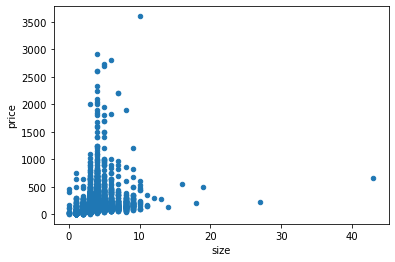

In [12]:
#scatter plot size/price
var = 'size'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price');

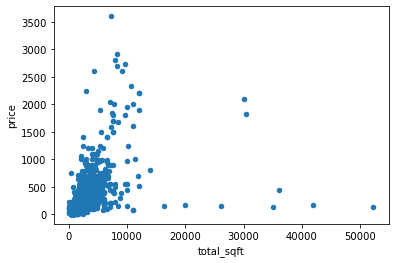

In [13]:
#scatter plot total_sqft/price
var = 'total_sqft'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price');

<AxesSubplot:xlabel='bath', ylabel='price'>

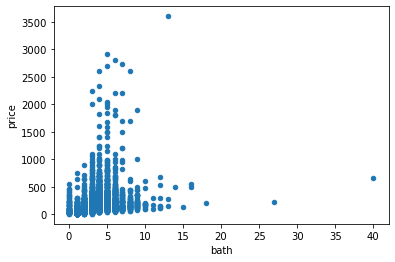

In [14]:
#scatter plot bath/price
var = 'bath'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price')

<AxesSubplot:xlabel='location', ylabel='price'>

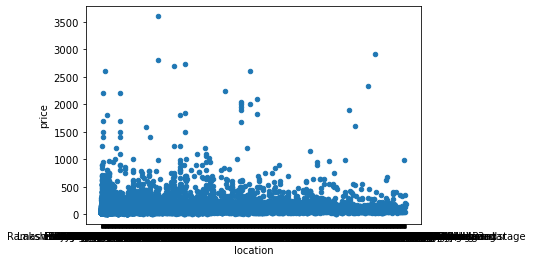

In [15]:
#scatter plot balcony/price
var = 'location'
data = pd.concat([full_df['price'], full_df[var]], axis=1)
data.plot.scatter(x=var, y='price')

<AxesSubplot:>

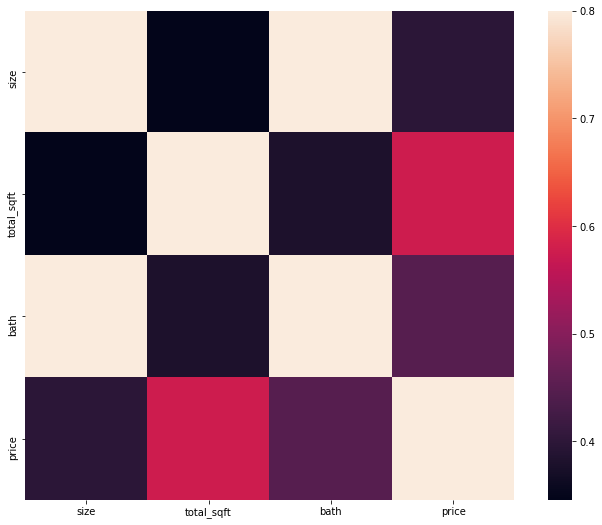

In [16]:
#correlation matrix
corrmat = full_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [17]:
#Using z_scores to remove outliers


cols = ['size', 'total_sqft', 'bath']


def z_score(full_df):
    full_df.columns = [x + "_zscore" for x in full_df.columns.tolist()]
    return ((full_df - full_df.mean())/full_df.std(ddof=0))

In [18]:
z_scores = z_score(full_df[cols])
z_scores['ID'] = z_scores.index
z_scores

,size_zscore,total_sqft_zscore,bath_zscore,ID
0,-0.616724,-0.406689,-0.501216,0
1,0.924362,0.840123,1.717036,1
2,0.153819,-0.096601,-0.501216,2
3,0.153819,-0.031192,0.238201,3
4,-0.616724,-0.290406,-0.501216,4
...,...,...,...,...
13315,1.694905,1.528938,0.977619,13315
13316,0.924362,1.647643,1.717036,13316
13317,-0.616724,-0.338050,-0.501216,13317
13318,0.924362,2.527033,0.977619,13318


In [19]:
full_df['ID'] = full_df.index
full_df = pd.merge(full_df, z_scores)
full_df

,location,size,total_sqft,bath,price,ID,size_zscore,total_sqft_zscore,bath_zscore
0,Electronic City Phase II,2,1056.0,2.0,39.07,0,-0.616724,-0.406689,-0.501216
1,Chikka Tirupathi,4,2600.0,5.0,120.00,1,0.924362,0.840123,1.717036
2,Uttarahalli,3,1440.0,2.0,62.00,2,0.153819,-0.096601,-0.501216
3,Lingadheeranahalli,3,1521.0,3.0,95.00,3,0.153819,-0.031192,0.238201
4,Kothanur,2,1200.0,2.0,51.00,4,-0.616724,-0.290406,-0.501216
...,...,...,...,...,...,...,...,...,...
13315,Whitefield,5,3453.0,4.0,231.00,13315,1.694905,1.528938,0.977619
13316,Richards Town,4,3600.0,5.0,400.00,13316,0.924362,1.647643,1.717036
13317,Raja Rajeshwari Nagar,2,1141.0,2.0,60.00,13317,-0.616724,-0.338050,-0.501216
13318,Padmanabhanagar,4,4689.0,4.0,488.00,13318,0.924362,2.527033,0.977619


In [20]:
full_df = full_df.loc[full_df['size_zscore'].abs()<=3]
full_df = full_df.loc[full_df['total_sqft_zscore'].abs()<=3]
full_df = full_df.loc[full_df['bath_zscore'].abs()<=3]
full_df = full_df.drop(columns =['size_zscore','total_sqft_zscore','bath_zscore','ID'])
full_df.reset_index(drop=True, inplace=True)
full_df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056.0,2.0,39.07
1,Chikka Tirupathi,4,2600.0,5.0,120.00
2,Uttarahalli,3,1440.0,2.0,62.00
3,Lingadheeranahalli,3,1521.0,3.0,95.00
4,Kothanur,2,1200.0,2.0,51.00
...,...,...,...,...,...
12865,Whitefield,5,3453.0,4.0,231.00
12866,Richards Town,4,3600.0,5.0,400.00
12867,Raja Rajeshwari Nagar,2,1141.0,2.0,60.00
12868,Padmanabhanagar,4,4689.0,4.0,488.00


In [21]:
Y_train = full_df['price']
del full_df['price']

#Converting the saleprice with Logarithms to over come the high skewness and the outliers
Y_train = np.log1p(Y_train) 

In [22]:
#convert categorical variable into dummy
full_df = pd.get_dummies(full_df)
full_df

,size,total_sqft,bath,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,location_ Electronic City,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,2,1056.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2600.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1440.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1521.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1200.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,5,3453.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12866,4,3600.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12867,2,1141.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12868,4,4689.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
full_df.fillna(0, inplace=True)
train_set = full_df
train_set

,size,total_sqft,bath,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,location_ Electronic City,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,2,1056.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2600.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1440.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1521.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1200.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,5,3453.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12866,4,3600.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12867,2,1141.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12868,4,4689.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:

X_train, X_test, y_train, y_test = train_test_split(train_set, Y_train, test_size=0.2, random_state=42)

In [48]:
X_train

,size,total_sqft,bath,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,location_ Electronic City,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
7529,3,1820.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,3,1160.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9396,3,1640.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,3,1400.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123,3,1875.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2500.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,2,1140.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,4,1750.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2,1116.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=-1, oob_score=False, random_state=5,
                      verbose=0, warm_start=False)

In [42]:
reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, n_estimators=300, n_jobs=-1,
                      random_state=5)

In [43]:
Y_pred = reg.predict(X_test)
print(Y_pred)

[3.93385578 4.0013409  4.16969313 ... 4.21693807 5.50934566 4.37036135]


In [44]:
reg.score(X_test,y_test)

0.7742974425312307

In [45]:
print('Random Forest Regression for Test RMSE',np.sqrt(mean_squared_error(y_test,Y_pred)))
print('Random Forest Regression for Test MSE',mean_squared_error(y_test,Y_pred))
print('Random Forest Regression for Test MAE',mean_absolute_error(y_test,Y_pred))

Random Forest Regression for Test RMSE 0.318834858898931
Random Forest Regression for Test MSE 0.10165566724910122
Random Forest Regression for Test MAE 0.21612298119815368


In [51]:
import pickle
filename = 'BangloreHousePrediction.pkl'
pickle.dump(reg,open(filename,'ab'))

# Load the Model back from file
with open(filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

RandomForestRegressor(max_depth=100, n_estimators=300, n_jobs=-1,
                      random_state=5)